# Experiments with Python code in Doc2Vec

In [1]:
import multiprocessing
from pathlib import Path
import ast
import astor
import tokenize
import io
import csv

import gensim.models.doc2vec
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"


In [2]:
test_code_dir = Path('test_data')
train_code_dir = Path('training_data')
models_dir = Path('models')

In [3]:
def split_methods(code):
    """Parse Python files into separate methods

        :param code: Python code to parse.
        :rtype: list
    """
    funcs = []
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                func = astor.to_source(node)
                funcs.append(func)
    except:
        pass

    if not funcs:
        funcs = code  # just send everything back
    return funcs

In [4]:
def read_train_corpus():
    count = -1
    dict = {}
    for i, file in enumerate(train_code_dir.glob('./python_projects/**/*.py')):
        if not file.is_file():  # oddly, some of these are not files
            continue
        with file.open() as f:
            try:
                code = f.read()
                methods = split_methods(code)
                for method in methods:
                    tokens = list(tokenize.generate_tokens(io.StringIO(method).readline))
                    tokens = [token for t in tokens if t.type == tokenize.NAME or t.type == tokenize.OP for token in t.string.split(" ")]
                    if tokens:
                        count += 1
                        path = file.__fspath__()
                        dict[count] = path
                        yield TaggedDocument(tokens, [count])
            except tokenize.TokenError as te:
                # print("%s: %s" % (type(te).__name__, te.args))
                pass
            except UnicodeDecodeError as e:
                # print("%s: %s" % (type(e).__name__, e))
                pass
            except Exception as e:
                print("%s: %s" % (type(e).__name__, e))
                pass
     
        if i % 10000 == 0:
            print("Processed %s records" % i)
        if i > 25000:
            break
            
    # also include test corpus in training! 
    for programming_language in test_code_dir.glob('./Python'):
        if not programming_language.is_dir():
            continue
        for programming_task in programming_language.glob('./*'):
            if not programming_task.is_dir():
                continue
            for implementation in programming_task.glob('./*'):
                with implementation.open() as f:
                    try:
                        code = f.read()  # don't split rosetta files into methods; learn them as a single vector
                        tokens = list(tokenize.generate_tokens(io.StringIO(code).readline))
                        tokens = [token for t in tokens if t.type == tokenize.NAME or t.type == tokenize.OP for token in t.string.split(" ")]
                        if tokens:
                            count += 1
                            path = file.__fspath__()
                            dict[count] = path
                            yield TaggedDocument(tokens, [count])
                    except tokenize.TokenError as e:
                        # print("%s: %s" % (type(e).__name__, e))
                        pass
                    except IndentationError as e:
                        # print("%s: %s" % (type(e).__name__, e))
                        pass
                    except Exception as e:
                        print("%s: %s" % (type(e).__name__, e))
                        pass
                    
    # save map to csv
    with open(str(models_dir / 'python_doc_map.csv'), 'w', newline='') as csvfile:
        w = csv.writer(csvfile)
        for key, val in dict.items():
            w.writerow([key, val])


%time train_corpus = list(read_train_corpus())
print("Training corpus size: %s" % len(train_corpus))


Processed 0 records


Processed 10000 records


Processed 20000 records


CPU times: user 5min 34s, sys: 6.23 s, total: 5min 40s
Wall time: 5min 52s
Training corpus size: 1329283


In [5]:
def read_test_corpus():
    color_val = 0
    for programming_language in test_code_dir.glob('./Python'):
        if not programming_language.is_dir():
            continue
        for programming_task in programming_language.glob('./*'):
            if not programming_task.is_dir():
                continue
            color_val += 1
            for implementation in programming_task.glob('./*'):
                with implementation.open() as f:
                    try:
                        code = f.read()
                        tokens = list(tokenize.generate_tokens(io.StringIO(code).readline))
                        tokens = [token for t in tokens if t.type == tokenize.NAME or t.type == tokenize.OP for token in t.string.split(" ")]
                        if tokens:
                            # print("Task: %s; Color: %s" % (programming_task.name, color_val))
                            yield TaggedDocument(tokens, [programming_task.name, implementation.name, programming_language.name, color_val])
                    except tokenize.TokenError as e:
                        # print("%s: %s" % (type(e).__name__, e))
                        pass
                    except IndentationError as e:
                        # print("%s: %s" % (type(e).__name__, e))
                        pass
                    except Exception as e:
                        print("%s: %s" % (type(e).__name__, e))
                        pass

              
test_corpus = list(read_test_corpus())
print("Test corpus size: %s" % len(test_corpus))

Test corpus size: 659


In [6]:
# doc2vec parameters
vector_size = 100
window_size = 8
min_count = 5
sampling_threshold = 1e-5
negative_size = 5
epochs = 20
dm = 0  # 0 = dbow; 1 = dmpv
worker_count = multiprocessing.cpu_count()  # number of parallel processes

In [7]:
%%time
model = Doc2Vec(train_corpus,
                vector_size=vector_size,
                window=window_size,
                min_count=min_count,
                sample=sampling_threshold,
                negative=negative_size,
                dbow_words=1,
                epochs=epochs,
                dm=dm,
                workers=worker_count)


CPU times: user 35min 48s, sys: 16min 8s, total: 51min 57s
Wall time: 30min 55s


In [8]:
model.save(str(models_dir / "github-python-vectors.bin"))

In [9]:
model.wv.most_similar('i')

[('range', 0.8060250282287598),
 ('enumerate', 0.7499897480010986),
 ('j', 0.7439063787460327),
 ('len', 0.7352942228317261),
 ('append', 0.7331555485725403),
 ('-', 0.7302388548851013),
 ('for', 0.7267324924468994),
 ('in', 0.6907938718795776),
 ('+', 0.6652678847312927),
 ('>', 0.6622821688652039)]

In [10]:
model.wv.most_similar('count')

[('old_history_docs', 0.5424256324768066),
 ('sporadic', 0.5413505434989929),
 ('FooAccount', 0.536583423614502),
 ('ShortMessage', 0.5307718515396118),
 ('size_g', 0.5300509929656982),
 ('vol_glance_meta_rows', 0.5294128060340881),
 ('qos_rows', 0.529043972492218),
 ('vol_type_proj_rows', 0.5289561152458191),
 ('snap_rows', 0.5260054469108582),
 ('action_present', 0.5234737992286682)]

In [11]:
import scipy

sieve9 = [doc for doc in test_corpus if doc.tags[1] == 'sieve-of-eratosthenes-9.py'][0]
sieve11 = [doc for doc in test_corpus if doc.tags[1] == 'sieve-of-eratosthenes-11.py'][0]

sieve9_vector = model.infer_vector(sieve9.words, steps=200)
sieve11_vector = model.infer_vector(sieve11.words, steps=200)

dist = scipy.spatial.distance.cosine(sieve9_vector, sieve11_vector)
print(dist)


0.4603193998336792


In [12]:
dict = {}
with open(str(models_dir / 'python_doc_map.csv'), newline='') as csvfile:
    r = csv.reader(csvfile)
    for row in r:
        dict[int(row[0])] = row[1]

sims = model.docvecs.most_similar([sieve11_vector])
print(dict[0])
f = Path(dict[sims[0][0]])
print(f.name)
print("Similarity: %s" % sims[0][1])
with f.open() as fin:
    print(fin.read(), end="")

training_data/python_projects/treeio/treeio/manage.py
hangman.py
Similarity: 0.9071098566055298
from string import ascii_lowercase
import sys

from movies import get_movie as get_word  # keep interface generic
from graphics import hang_graphics

ASCII = list(ascii_lowercase)
HANG_GRAPHICS = list(hang_graphics())
ALLOWED_GUESSES = len(HANG_GRAPHICS)
PLACEHOLDER = '_'


class Hangman(object):
    pass 

# or use functions ...


if __name__ == '__main__':
    if len(sys.argv) > 1:
        word = sys.argv[1]
    else:
        word = get_word()
    print(word)

    # init / call program


In [13]:
docs = [{'name': doc.tags[0], 'vec': model.infer_vector(doc.words, steps=200), 'color': doc.tags[3]} for doc in test_corpus]
num_colors = docs[-1]['color']

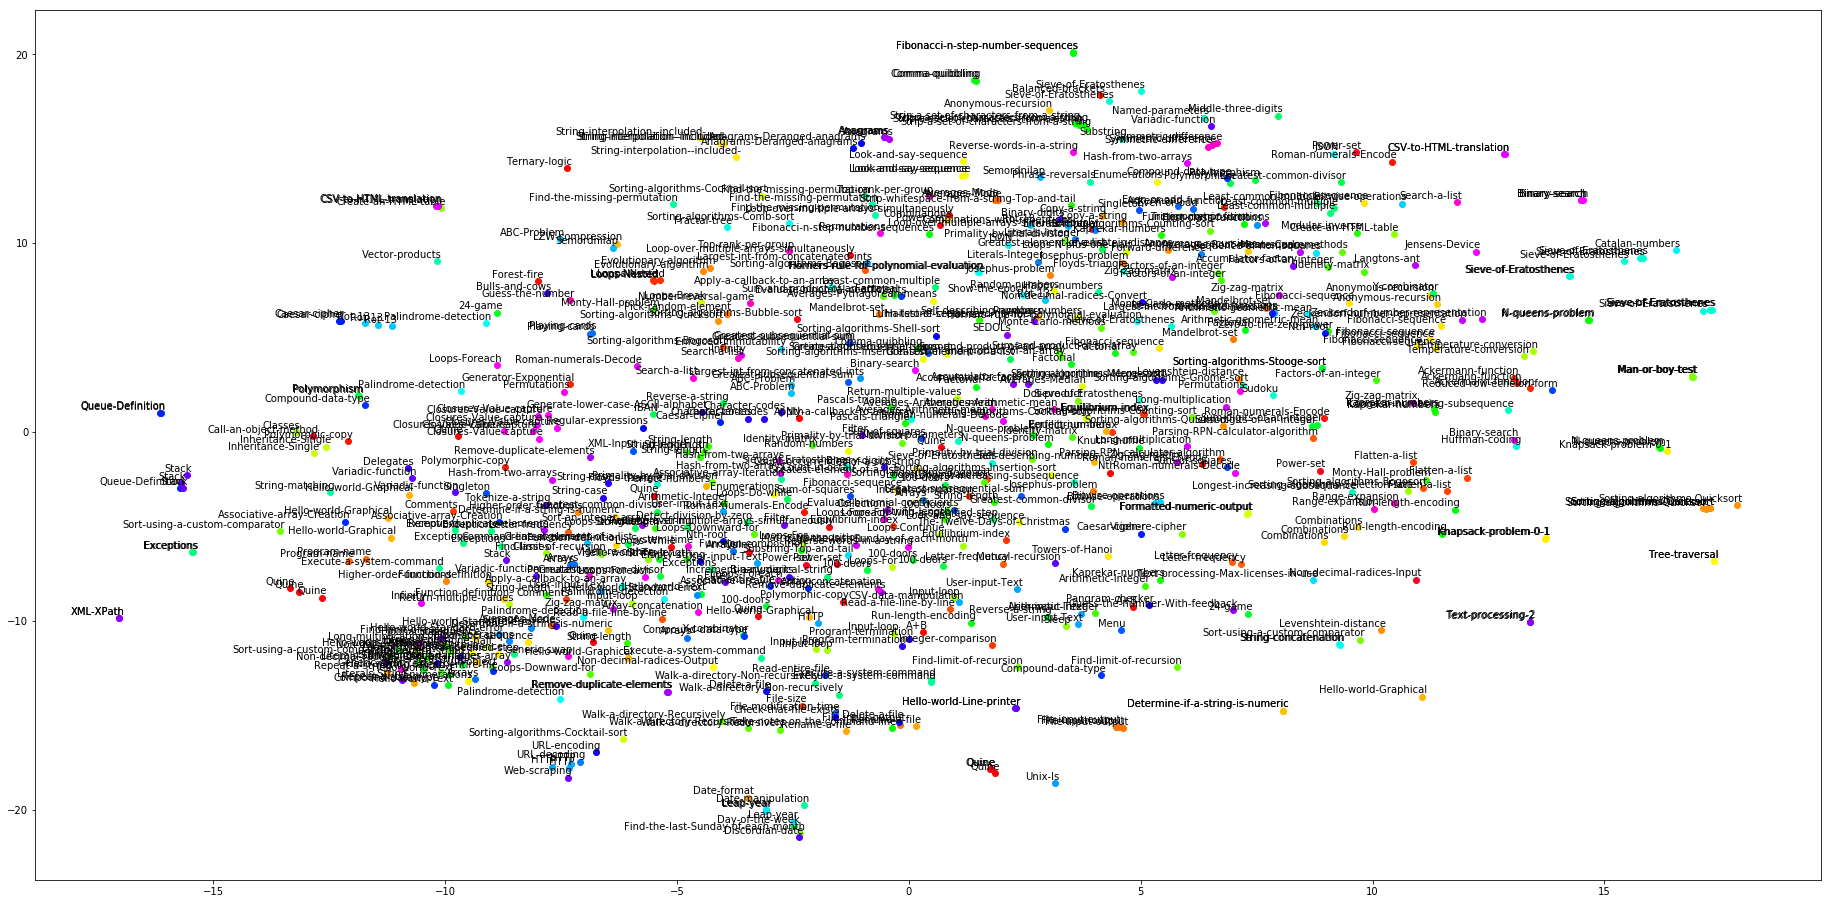

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import matplotlib
from sklearn.manifold import TSNE

matplotlib.rcParams['figure.figsize'] = (32, 16)

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
twoDimVecs = tsne.fit_transform([doc['vec'] for doc in docs])

cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=num_colors-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots()
for doc, twoDimVec in zip(docs, twoDimVecs):
    ax.scatter(twoDimVec[0], twoDimVec[1], color=scalarMap.to_rgba(doc['color']))
    plt.annotate(doc['name'],
                 xy=(twoDimVec[0], twoDimVec[1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()